In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML Workflow

A construção dos modelos de Machine Learning muitas vezes depende mais da qualidade dos dados e dos cuidados tomados contra **data leakage** do que das escolhas técnicas do cientista de dados. Hoje veremos um *workflow* padrão para a trabalhar com conjuntos de dados - garantindo que não exista leakage e que nosso conjunto de treinamento está limpo.

Além disso, devemos sempre lembrar que os modelos preditivos **existem para fazer previsões**! Um dos maiores problemas hoje em dia no campo de machine learning é a dificuldade em levar um modelo da fase de protótipo à produção. Vamos discutir ao longo da aula pontos sensíveis na implantação de um modelo e que como podemos evitar armadilhas.

In [2]:
tb_hotel = pd.read_csv("data/tb_hotel_aula.csv")
tb_hotel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   is_cancelled             119390 non-null  int64  
 1   lead_time                119390 non-null  int64  
 2   country                  118902 non-null  object 
 3   company                  6797 non-null    float64
 4   children                 119386 non-null  float64
 5   adults                   119390 non-null  int64  
 6   meal                     119390 non-null  object 
 7   reservation_status_date  119390 non-null  object 
 8   booking_changes          119390 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 8.2+ MB


## Evitando *leakage*

*Data leakage* é um erro extremamente comum no campo de ciência de dados. Em uma análise feita para um [artigo da revista Nature](https://www.nature.com/articles/d41586-022-02035-w), em um review de 340 artigos, 329 apresentavam **falhas em reprodutibilidade**. Outro estudo, conduzido na Universidade de Birmingham, apontou que menos de 5% dos artigos médicos utilizando Machine Learning se preocupavam com a possibilidade de implantação dos modelos em ambiente clínicos.

*Leakage* acontece quando não garantimos, na etapa de construção do modelo, que estamos operando dentro das mesmas condições que o modelo irá operar quando estiver em produção. Para garantir estas condições precisamos cumprir duas etapas:

1. **Limpeza de variáveis**: como conjuntos de dados utilizados na construção de modelos são sempre dados históricos, precisamos garantir que as variáveis que estamos utilizando estarão disponíveis do momento em que o modelo for utilizado para fazer previsões;
1. **Avaliação de Erro em conjunto Teste**: para modelos preditivos, precisamos avaliar o erro de previsão destes modelos em conjuntos de dados que não foram utilizados nas etapas de aprendizagem.

Na primeira etapa **precisamos descobrir e entender como o dado é produzido**: quais sistemas são utilizados, quais são os *fatos transacionais*, e, finalmente, quais as informações que estarão disponíveis no momento de predição. Além disso, precisamos **garantir** que as etapas de pré-processamento do modelo **funcionarão** sobre dados futuros!

Excluindo variáveis que não estarão disponíveis em sua forma histórica em dados presentes, a divisão test/train possibilita que avaliemos o modelo em todas as suas etapas: pré-processamento, aprendizagem e avaliação.

In [3]:
from sklearn.model_selection import train_test_split


In [4]:
X_var = ["lead_time", "country", "company", "children", "adults", "meal"]
y_var = "is_cancelled"
X = tb_hotel[X_var]
y = tb_hotel[y_var]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


## Tratando NAs

Para tratar de valores NA em um modelo de machine learning, não basta *excluir linhas*! Temos que lembrar que, em produção, os dados alimentados ao modelo poderão conter NAs. Precisamos criar mecânismos que **preencham** esses valores ou então desncosiderar as variáveis que podem conte-los.

In [11]:
X_train.isna().sum() / X_train.shape[0]


lead_time    0.000000
country      0.004054
company      0.943133
children     0.000034
adults       0.000000
meal         0.000000
dtype: float64

### Tratativas Manuais

A melhor forma de tratar valores NA é compreendendo **porque eles existem** em uma dada variável. Se conhecemos as causas por trás destes valores, podemos criar tratativas diretas e específicas à cada variável.

In [12]:
mask_na_company = X_train["company"].isna()

X_train.loc[mask_na_company, "is_company"] = 0
X_train.loc[~mask_na_company, "is_company"] = 1


### Imputando valores

Caso não seja possível elucidar porque certas variáveis contém NAs, podemos recorrer a **imputação de valores**. A imputação pode ser arriscada se os valores não foram gerados por erros de sistema, ou então se tem uma estrutura subjacente, portanto devemos utiliza-la apenas após estudar o processo de geração de dados e garantir que estes valores são:

1. Raros;
1. Causados por falhas no sistema;

In [14]:
X_train['country'].value_counts()

PRT    36487
GBR     9027
FRA     7792
ESP     6469
DEU     5489
       ...  
BDI        1
ATA        1
MWI        1
NAM        1
GUY        1
Name: country, Length: 166, dtype: int64

In [13]:
from sklearn.impute import SimpleImputer


In [15]:
country_imputer = SimpleImputer(strategy="most_frequent")

country_imputer.fit(X_train[["country"]])


SimpleImputer(strategy='most_frequent')

In [16]:
children_imputer = SimpleImputer(strategy="median")

children_imputer.fit(X_train[["children"]])


SimpleImputer(strategy='median')

In [17]:
X_train["country_imp"] = country_imputer.transform(X_train[["country"]])
X_train["children_imp"] = children_imputer.transform(X_train[["children"]])


In [20]:
X_train.loc[X_train["country"].isna(), ["country", "country_imp"]]


,country,country_imp
14003,NaN,PRT
14172,NaN,PRT
23583,NaN,PRT
7092,NaN,PRT
14579,NaN,PRT
...,...,...
14068,NaN,PRT
14331,NaN,PRT
13871,NaN,PRT
14513,NaN,PRT


In [21]:
X_train.loc[X_train["children"].isna(), ["children", "children_imp"]]


,children,children_imp
41160,NaN,0.0
40679,NaN,0.0
40600,NaN,0.0


### Removendo colunas

Caso uma coluna não tenha uma trativa direta e contém valores NA demais para imputação, devemos desconsiderar esta variável no nosso modelo.

In [22]:
X_train = X_train.drop(["company", "country", "children"], axis=1)
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 89542 entries, 10819 to 117150
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lead_time     89542 non-null  int64  
 1   adults        89542 non-null  int64  
 2   meal          89542 non-null  object 
 3   is_company    89542 non-null  float64
 4   country_imp   89542 non-null  object 
 5   children_imp  89542 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 4.8+ MB


## Lidando com Variáveis Categóricas

As variáveis categóricas apresentam algumas dificuldades quando utilizadas em modelos:

1. No caso de One-Hot encoding, devemos garantir que nosso programa **saiba lidar com níveis novos da variável**;
1. Além disso, precisamos garantir que não criemos variáveis dummies para níveis com poucas observações (níveis raros).

No caso de utilizarmos variáveis **Ordinais**, precisamos garantir que a **codificação** destas variáveis faça sentido!

In [24]:
X_train.select_dtypes(exclude="number").head()


,meal,country_imp
10819,BB,IRL
81182,BB,FRA
13763,BB,PRT
8340,BB,PRT
29012,HB,PRT


In [25]:
cat_vars = ["country_imp"]
ord_vars = ["meal"]


### Tratando níveis raros

A forma mais comum de tratar níveis raros é agrupando-os em uma nova categoria.

In [29]:
tb_niveis_country = (
    X_train[cat_vars].value_counts().reset_index().rename({0: "num_obs"}, axis=1)
)
tb_niveis_country


,country_imp,num_obs
0,PRT,36850
1,GBR,9027
2,FRA,7792
3,ESP,6469
4,DEU,5489
...,...,...
161,GLP,1
162,SDN,1
163,DMA,1
164,DJI,1


In [42]:
mask_niveis = tb_niveis_country["num_obs"] > 500

tb_niveis_country.loc[mask_niveis, "country_grp"] = tb_niveis_country["country_imp"]
tb_niveis_country.loc[~mask_niveis, "country_grp"] = "Others"

,country_imp,num_obs,country_grp
0,PRT,36850,PRT
1,GBR,9027,GBR
2,FRA,7792,FRA
3,ESP,6469,ESP
4,DEU,5489,DEU
...,...,...,...
95,GNB,7,Others
96,BIH,7,Others
97,DOM,7,Others
98,CUB,7,Others


In [44]:
tb_niveis_country.index = tb_niveis_country["country_imp"]
tb_niveis_country

,country_imp,num_obs,country_grp
country_imp,,,
PRT,PRT,36850,PRT
GBR,GBR,9027,GBR
FRA,FRA,7792,FRA
ESP,ESP,6469,ESP
DEU,DEU,5489,DEU
...,...,...,...
GLP,GLP,1,Others
SDN,SDN,1,Others
DMA,DMA,1,Others


In [45]:
tb_niveis_country = tb_niveis_country.drop(["num_obs", "country_imp"], axis=1)
tb_niveis_country

,country_grp
country_imp,
PRT,PRT
GBR,GBR
FRA,FRA
ESP,ESP
DEU,DEU
...,...
GLP,Others
SDN,Others
DMA,Others


In [47]:
dict_country = tb_niveis_country.to_dict()["country_grp"]
dict_country

{'PRT': 'PRT',
 'GBR': 'GBR',
 'FRA': 'FRA',
 'ESP': 'ESP',
 'DEU': 'DEU',
 'ITA': 'ITA',
 'IRL': 'IRL',
 'BEL': 'BEL',
 'BRA': 'BRA',
 'NLD': 'NLD',
 'USA': 'USA',
 'CHE': 'CHE',
 'CN': 'CN',
 'AUT': 'AUT',
 'SWE': 'SWE',
 'CHN': 'CHN',
 'POL': 'POL',
 'ISR': 'ISR',
 'NOR': 'Others',
 'RUS': 'Others',
 'ROU': 'Others',
 'FIN': 'Others',
 'DNK': 'Others',
 'AUS': 'Others',
 'AGO': 'Others',
 'LUX': 'Others',
 'MAR': 'Others',
 'TUR': 'Others',
 'HUN': 'Others',
 'ARG': 'Others',
 'JPN': 'Others',
 'CZE': 'Others',
 'IND': 'Others',
 'GRC': 'Others',
 'KOR': 'Others',
 'DZA': 'Others',
 'HRV': 'Others',
 'SRB': 'Others',
 'MEX': 'Others',
 'EST': 'Others',
 'LTU': 'Others',
 'IRN': 'Others',
 'BGR': 'Others',
 'NZL': 'Others',
 'ZAF': 'Others',
 'COL': 'Others',
 'UKR': 'Others',
 'CHL': 'Others',
 'MOZ': 'Others',
 'SVK': 'Others',
 'SVN': 'Others',
 'THA': 'Others',
 'ISL': 'Others',
 'TWN': 'Others',
 'ARE': 'Others',
 'LVA': 'Others',
 'CYP': 'Others',
 'SAU': 'Others',
 'SGP': 'Oth

In [49]:
X_train["country_grp"] = X_train["country_imp"].map(dict_country)
X_train = X_train.drop("country_imp", axis=1)
X_train.head()


,lead_time,adults,meal,is_company,children_imp,country_grp
10819,175,2,BB,0.0,0.0,IRL
81182,68,2,BB,0.0,0.0,FRA
13763,29,2,BB,0.0,0.0,PRT
8340,191,2,BB,0.0,0.0,PRT
29012,47,2,HB,0.0,0.0,PRT


In [50]:
X_train['country_grp'].value_counts()

PRT       36850
GBR        9027
FRA        7792
ESP        6469
Others     6049
DEU        5489
ITA        2876
IRL        2528
BEL        1748
BRA        1658
NLD        1579
USA        1576
CHE        1308
CN          945
AUT         941
SWE         786
CHN         746
POL         672
ISR         503
Name: country_grp, dtype: int64

### One-Hot Encoding

Após tratarmos níveis raros, podemos utilizar o `OneHotEncoder` para criar nossa variáveis dummies de forma robusta, garantindo que novos níveis em dados futuros (ou no conjunto de teste) não causarão erros em nosso modelo.

In [51]:
from sklearn.preprocessing import OneHotEncoder


In [52]:
ohe_vars = ["country_grp"]


In [53]:
ohe = OneHotEncoder(sparse=False, drop="first", handle_unknown="ignore")

ohe.fit(X_train[ohe_vars])


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [54]:
ohe.transform(X_train[ohe_vars])


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
ohe.get_feature_names_out()

array(['country_grp_BEL', 'country_grp_BRA', 'country_grp_CHE',
       'country_grp_CHN', 'country_grp_CN', 'country_grp_DEU',
       'country_grp_ESP', 'country_grp_FRA', 'country_grp_GBR',
       'country_grp_IRL', 'country_grp_ISR', 'country_grp_ITA',
       'country_grp_NLD', 'country_grp_Others', 'country_grp_POL',
       'country_grp_PRT', 'country_grp_SWE', 'country_grp_USA'],
      dtype=object)

In [57]:
tb_dummies_cat = pd.DataFrame(
    ohe.transform(X_train[ohe_vars]), 
    columns=ohe.get_feature_names_out(), 
    index = X_train.index
)
tb_dummies_cat.head()


,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CHN,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ISR,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_POL,country_grp_PRT,country_grp_SWE,country_grp_USA
10819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Variáveis Ordinais

Além do One-Hot Encoding, podemos converter nossas categorias em variáveis numéricas (se elas possuem um ordenamento natural). Vamos utilizar o `OrdinalEncoder` para tratar a variável `meal`.

In [58]:
from sklearn.preprocessing import OrdinalEncoder


In [59]:
X_train["meal"].value_counts()


BB           69289
HB           10858
SC            7910
Undefined      886
FB             599
Name: meal, dtype: int64

In [62]:
dict_meal = {
    'BB' : 'BB', 
    'HB' : 'HB', 
    'SC' : 'SC', 
    'Undefined' : 'SC', 
    'FB' : 'FB'
}

X_train["meal_grp"] = X_train["meal"].map(dict_meal)

In [63]:
ordinal = OrdinalEncoder(categories=[["SC", "BB", "HB", "FB"]])
ordinal.fit(X_train[["meal_grp"]])


OrdinalEncoder(categories=[['SC', 'BB', 'HB', 'FB']])

In [64]:
X_train["num_meal"] = ordinal.transform(X_train[["meal_grp"]])
X_train


,lead_time,adults,meal,is_company,children_imp,country_grp,num_meal,meal_grp
10819,175,2,BB,0.0,0.0,IRL,1.0,BB
81182,68,2,BB,0.0,0.0,FRA,1.0,BB
13763,29,2,BB,0.0,0.0,PRT,1.0,BB
8340,191,2,BB,0.0,0.0,PRT,1.0,BB
29012,47,2,HB,0.0,0.0,PRT,2.0,HB
...,...,...,...,...,...,...,...,...
97689,21,1,BB,0.0,0.0,GBR,1.0,BB
11508,263,2,BB,0.0,0.0,IRL,1.0,BB
69853,1,1,BB,1.0,0.0,PRT,1.0,BB
40597,6,1,BB,0.0,2.0,PRT,1.0,BB


## Encontrando Outliers

Valores extremos em variáveis numéricas são como níveis raros em variáveis categóricas. Muitas vezes, estes valores podem impactar o resultado de um modelo, mesmo tendo um pequeno volume de observações. No entanto, devemos nos lembrar que o filtro de outliers **só pode ser feito no conjunto de treinamento!** 

Afinal, essas observações fazem parte do processo de geração dos dados - nosso modelo precisará fazer previsões para esses valores. Remove-los do conjunto de treinamento garante que nosso modelo *não aprenda pela exceção!*

Vamos aprender algumas formas diferentes de limpar outliers, entendendo suas forças e fragilidades.

<AxesSubplot:ylabel='lead_time'>

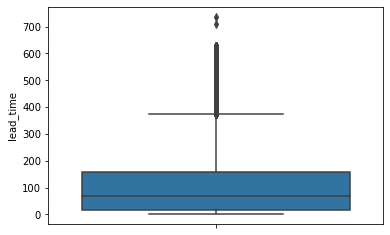

In [65]:
sns.boxplot(data=X_train, y="lead_time")


### Regra n-Sigma: 68-95-99

A regra 68-95-99 de limpeza é calcada na forma da distribuição normal: 99% dos dados estão a menos de 3 desvios padrões da média. Muitas vezes, filtramos outliers utilizando o intervalo de 2-sigmas, descartando 5% das observações com valores mais extremos.

A regra `n-Sigma` é ótima se nossa variável é **simétrica**, ou seja, se a variação para cima da média é semelhante a variação para baixo da média. Caso contrário, podemos descartar muitos dados em um eixo só: por exemplo removendo estes 5% só da parte superior da distribuição.

In [66]:
mu_lead_time = X_train["lead_time"].mean()
sig_lead_time = X_train["lead_time"].std()


In [71]:
mask_95 = (X_train["lead_time"] > (mu_lead_time - 2 * sig_lead_time)) & (
    X_train["lead_time"] < (mu_lead_time + 2 * sig_lead_time)
)
print(mask_95.sum() / X_train.shape[0])


0.9492528645775167


<AxesSubplot:xlabel='out_2sig', ylabel='lead_time'>

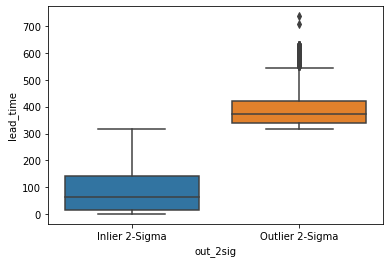

In [73]:
X_train.loc[mask_95, "out_2sig"] = "Inlier 2-Sigma"
X_train.loc[~mask_95, "out_2sig"] = "Outlier 2-Sigma"
sns.boxplot(data=X_train, x="out_2sig", y="lead_time")


Qual o problema com a exclusão acima?

#### Desigualdade de Chebyshev

A desigualdade de Chebyshev é uma extensão da regra n-Sigma para **qualquer distribuição comum (simétrica ou assimétrica)**: ela nos garante que 96% dos dados estarão à 5 desvios padrões da média.

Essa estimativa é extremamente conservadora - o que faz com que exclusão de outliers seja suave. Esta é uma regra **que sempre podemos aplicar sobre variáveis numéricas!**

In [76]:
mask_cheby = (X_train["lead_time"] > (mu_lead_time - 5 * sig_lead_time)) & (
    X_train["lead_time"] < (mu_lead_time + 5 * sig_lead_time)
)
print(mask_cheby.sum() / X_train.shape[0])


0.9999776641129302


<AxesSubplot:xlabel='out_cheby', ylabel='lead_time'>

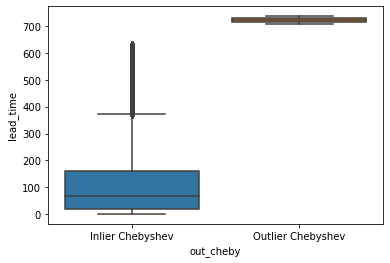

In [77]:
X_train.loc[mask_cheby, "out_cheby"] = "Inlier Chebyshev"
X_train.loc[~mask_cheby, "out_cheby"] = "Outlier Chebyshev"
sns.boxplot(data=X_train, x="out_cheby", y="lead_time")


### Utilizando a IQR

Podemos utilizar a distância interquartil para estimar thresholds de outliers assimétricos. A regra IQR funciona como um meio termo robusto entre a desigualdade de Chebyshev e a regra n-Sigma.

Como esta regra utiliza os *quantis* de uma variável, devemos tomar cuidado com variáveis extremamente concentradas (algo comum em variáveis de contagem por exemplo): nesses cassos muitas vezes o terceiro quartil é igual ao primeiro quartil - levando à uma exclusão de toda variação presente na variável.

In [80]:
q25 = np.quantile(X_train["lead_time"], 0.25)
q75 = np.quantile(X_train["lead_time"], 0.75)
iqr = q75 - q25

In [81]:
mask_iqr = (X_train["lead_time"] > (q25 - 1.5 * iqr)) & (
    X_train["lead_time"] < (q75 + 1.5 * iqr)
)
print(mask_iqr.sum() / X_train.shape[0])


0.9747716155547117


<AxesSubplot:xlabel='out_iqr', ylabel='lead_time'>

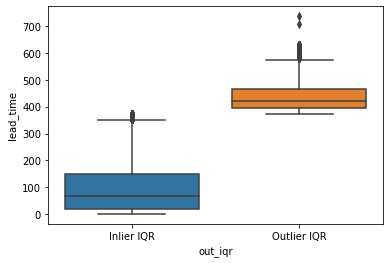

In [82]:
X_train.loc[mask_iqr, "out_iqr"] = "Inlier IQR"
X_train.loc[~mask_iqr, "out_iqr"] = "Outlier IQR"
sns.boxplot(data=X_train, x="out_iqr", y="lead_time")


## Criando normalizador

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
num_var = ['lead_time', 'adults', 'children_imp', 'num_meal']

In [85]:
scaler = StandardScaler()
scaler.fit(X_train[num_var])

StandardScaler()

In [86]:
scaler.get_feature_names_out()

array(['lead_time', 'adults', 'children_imp', 'num_meal'], dtype=object)

# Construindo nossos conjuntos de treinamento e teste

1. Podemos alterar o número de linhas **APENAS** no **conjunto de treinamento**;

    1. *Isso inclui qualquer operação de limpeza de NAs e outliers.*
    
1. Qualquer etapa de **aprendizagem** pode ser executada apenas no **conjunto de treinamento**;

    1. *Isso inclui encoders (ordinais e OH), imputadores, normalizadores e agrupamento de valores categóricos.*
    
1. Toda transformação deve ser realizada **tanto no conjunto de teste quanto no conjunto final**.

## Finalizando nosso dataset de treinamento

In [87]:
mu_adults = X_train["adults"].mean()
sig_adults = X_train["adults"].std()
mask_cheby_adults = (X_train["adults"] > (mu_adults - 5 * sig_adults)) & (
    X_train["adults"] < (mu_adults + 5 * sig_adults)
)

In [88]:
mu_child = X_train["children_imp"].mean()
sig_child = X_train["children_imp"].std()
mask_cheby_child = (X_train["children_imp"] > (mu_child - 5 * sig_child)) & (
    X_train["children_imp"] < (mu_child + 5 * sig_child)
)

In [89]:
q25 = np.quantile(X_train["lead_time"], 0.25)
q75 = np.quantile(X_train["lead_time"], 0.75)
iqr = q75 - q25
mask_iqr_lead_time = (X_train["lead_time"] > (q25 - 1.5 * iqr)) & (
    X_train["lead_time"] < (q75 + 1.5 * iqr)
)

In [90]:
mask_inliner = (mask_iqr_lead_time) & (mask_cheby_child) & (mask_cheby_adults)
print(f"Removendo {np.round(100*(1-mask_inliner.sum()/X_train.shape[0]), 2)}% do Train-set")

Removendo 2.6% do Train-set


In [92]:
X_train_nout = X_train.loc[mask_inliner]
X_train_nout.head()

,lead_time,adults,meal,is_company,children_imp,country_grp,num_meal,meal_grp,out_2sig,out_cheby,out_iqr
10819,175,2,BB,0.0,0.0,IRL,1.0,BB,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
81182,68,2,BB,0.0,0.0,FRA,1.0,BB,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
13763,29,2,BB,0.0,0.0,PRT,1.0,BB,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
8340,191,2,BB,0.0,0.0,PRT,1.0,BB,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
29012,47,2,HB,0.0,0.0,PRT,2.0,HB,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR


In [93]:
X_train_numerical = X_train_nout[num_var]
X_train_numerical.head()

,lead_time,adults,children_imp,num_meal
10819,175,2,0.0,1.0
81182,68,2,0.0,1.0
13763,29,2,0.0,1.0
8340,191,2,0.0,1.0
29012,47,2,0.0,2.0


In [95]:
X_sca = pd.DataFrame(
    scaler.transform(X_train_numerical),
    columns = scaler.get_feature_names_out(),
    index = X_train_nout.index
)

In [96]:
X_sca

,lead_time,adults,children_imp,num_meal
10819,0.667408,0.242367,-0.260384,-0.073565
81182,-0.334738,0.242367,-0.260384,-0.073565
13763,-0.700005,0.242367,-0.260384,-0.073565
8340,0.817261,0.242367,-0.260384,-0.073565
29012,-0.531420,0.242367,-0.260384,1.947038
...,...,...,...,...
97689,-0.774932,-1.442963,-0.260384,-0.073565
11508,1.491602,0.242367,-0.260384,-0.073565
69853,-0.962249,-1.442963,-0.260384,-0.073565
40597,-0.915420,-1.442963,4.754730,-0.073565


In [97]:
ohe.transform(X_train_nout[ohe_vars])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [98]:
X_dum = pd.DataFrame(
    ohe.transform(X_train_nout[ohe_vars]),
    columns = ohe.get_feature_names_out(),
    index = X_train_nout.index
)
X_dum['is_company'] = X_train_nout['is_company']

In [99]:
X_train_final = pd.concat([X_sca, X_dum], axis = 1)
X_train_final.head()

,lead_time,adults,children_imp,num_meal,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CHN,country_grp_CN,country_grp_DEU,...,country_grp_IRL,country_grp_ISR,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_POL,country_grp_PRT,country_grp_SWE,country_grp_USA,is_company
10819,0.667408,0.242367,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81182,-0.334738,0.242367,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13763,-0.700005,0.242367,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8340,0.817261,0.242367,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29012,-0.531420,0.242367,-0.260384,1.947038,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Finalizando nosso dataset de test

In [101]:
mask_na_company = X_test["company"].isna()
X_test.loc[mask_na_company, "is_company"] = 0
X_test.loc[~mask_na_company, "is_company"] = 1
X_test.head()

,lead_time,country,company,children,adults,meal,is_company
12683,234,GBR,NaN,0.0,2,HB,0.0
77602,0,DEU,NaN,0.0,2,BB,0.0
88139,47,FRA,NaN,0.0,2,BB,0.0
40210,18,PRT,NaN,0.0,1,BB,0.0
105476,7,JPN,NaN,0.0,2,BB,0.0


In [102]:
X_test['country_imp'] = country_imputer.transform(X_test[["country"]])
X_test['children_imp'] = children_imputer.transform(X_test[["children"]])

X_test.head()

,lead_time,country,company,children,adults,meal,is_company,country_imp,children_imp
12683,234,GBR,NaN,0.0,2,HB,0.0,GBR,0.0
77602,0,DEU,NaN,0.0,2,BB,0.0,DEU,0.0
88139,47,FRA,NaN,0.0,2,BB,0.0,FRA,0.0
40210,18,PRT,NaN,0.0,1,BB,0.0,PRT,0.0
105476,7,JPN,NaN,0.0,2,BB,0.0,JPN,0.0


In [105]:
X_test['country_grp'] = X_test['country_imp'].map(dict_country)
X_test['country_grp'] = X_test['country_grp'].fillna('Others')
X_test.head()

,lead_time,country,company,children,adults,meal,is_company,country_imp,children_imp,country_grp
12683,234,GBR,NaN,0.0,2,HB,0.0,GBR,0.0,GBR
77602,0,DEU,NaN,0.0,2,BB,0.0,DEU,0.0,DEU
88139,47,FRA,NaN,0.0,2,BB,0.0,FRA,0.0,FRA
40210,18,PRT,NaN,0.0,1,BB,0.0,PRT,0.0,PRT
105476,7,JPN,NaN,0.0,2,BB,0.0,JPN,0.0,Others


In [107]:
X_test['meal_grp'] = X_test["meal"].map(dict_meal)
X_test['num_meal'] = ordinal.transform(X_test[["meal_grp"]])
X_test.head()

,lead_time,country,company,children,adults,meal,is_company,country_imp,children_imp,country_grp,meal_grp,num_meal
12683,234,GBR,NaN,0.0,2,HB,0.0,GBR,0.0,GBR,HB,2.0
77602,0,DEU,NaN,0.0,2,BB,0.0,DEU,0.0,DEU,BB,1.0
88139,47,FRA,NaN,0.0,2,BB,0.0,FRA,0.0,FRA,BB,1.0
40210,18,PRT,NaN,0.0,1,BB,0.0,PRT,0.0,PRT,BB,1.0
105476,7,JPN,NaN,0.0,2,BB,0.0,JPN,0.0,Others,BB,1.0


In [108]:
X_test_numerical = X_test.loc[:, num_var]
X_sca_test = pd.DataFrame(
    scaler.transform(X_test_numerical),
    columns = scaler.get_feature_names_out(),
    index = X_test_numerical.index
)

In [109]:
X_dum_test = pd.DataFrame(
    ohe.transform(X_test[ohe_vars]),
    columns = ohe.get_feature_names_out(),
    index = X_test.index
)
X_dum_test['is_company'] = X_test['is_company']

In [110]:
X_test_final = pd.concat([X_sca_test, X_dum_test], axis = 1)
X_test_final.head()

,lead_time,adults,children_imp,num_meal,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CHN,country_grp_CN,country_grp_DEU,...,country_grp_IRL,country_grp_ISR,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_POL,country_grp_PRT,country_grp_SWE,country_grp_USA,is_company
12683,1.219992,0.242367,-0.260384,1.947038,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77602,-0.971615,0.242367,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88139,-0.531420,0.242367,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40210,-0.803030,-1.442963,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
105476,-0.906054,0.242367,-0.260384,-0.073565,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Salvando nossos conjuntos de teste e treinamento

In [111]:
tb_train = X_train_final
tb_train['is_cancelled'] = y_train
tb_train.to_csv('data/tb_hotel_train_clean.csv', index = False)

In [112]:
tb_test = X_test_final
tb_test['is_cancelled'] = y_test
tb_test.to_csv('data/tb_hotel_test_clean.csv', index = False)

# VOLTAMOS 13H45

## **EXTRA** - Criando um *wrapper*

In [ ]:
def fit_objects(dados_treinamento):
    # Limpando outliers
    q25 = np.quantile(dados_treinamento["lead_time"], 0.25)
    q75 = np.quantile(dados_treinamento["lead_time"], 0.75)
    iqr = q75 - q25
    mask_iqr = (dados_treinamento["lead_time"] > (q25 - 1.5 * iqr)) & (dados_treinamento["lead_time"] < (q75 + 1.5 * iqr))
    dados_treinamento = dados_treinamento[mask_iqr].copy()
    
    # Criando imputers
    country_imputer = SimpleImputer(strategy="most_frequent")
    dados_treinamento['country_imp'] = country_imputer.fit_transform(dados_treinamento[["country"]])
    children_imputer = SimpleImputer(strategy="median")
    dados_treinamento['children_imp'] = children_imputer.fit_transform(dados_treinamento[["children"]])

    # Criando grupos de países
    tb_niveis_country = dados_treinamento[['country_imp']].value_counts().reset_index().rename({0 : 'num_obs'}, axis = 1)
    mask_niveis = tb_niveis_country["num_obs"] > (sum(tb_niveis_country["num_obs"]) * 0.01)
    tb_niveis_country.loc[mask_niveis, "country_grp"] = tb_niveis_country["country_imp"]
    tb_niveis_country.loc[~mask_niveis, "country_grp"] = "Others"
    tb_niveis_country.index = tb_niveis_country["country_imp"]
    tb_niveis_country = tb_niveis_country.drop(["num_obs", "country_imp"], axis=1)
    dict_country = tb_niveis_country.to_dict()["country_grp"]
    dados_treinamento['country_grp'] = dados_treinamento['country_imp'].map(dict_country)

    # Criando OrdinalEncoder para Meal
    ordinal = OrdinalEncoder(categories=[["Undefined", "SC", "BB", "HB", "FB"]])
    dados_treinamento['num_meal'] = ordinal.fit_transform(dados_treinamento[["meal"]])

    # Criando OneHotEncoder para variáveis categóricas
    ohe_var = ['country_grp']
    ohe = OneHotEncoder(sparse=False, drop="first", handle_unknown="ignore")
    ohe.fit(dados_treinamento[ohe_var])

    # Criando normalizador
    num_var = ['lead_time', 'adults', 'num_meal', 'children_imp']
    scaler = StandardScaler()
    scaler.fit(dados_treinamento[num_var])
    return country_imputer, children_imputer, dict_country, ohe, ordinal, scaler


def transform_data(dados_originais, country_imputer, children_imputer, dict_country, ohe, ordinal, scaler):
    mask_na_company = dados_originais["company"].isna()
    dados_originais.loc[mask_na_company, "is_company"] = 0
    dados_originais.loc[~mask_na_company, "is_company"] = 1

    dados_originais['country_imp'] = country_imputer.transform(dados_originais[["country"]])
    dados_originais['children_imp'] = children_imputer.transform(dados_originais[["children"]])
    dados_originais['country_grp'] = dados_originais['country_imp'].map(dict_country)
    dados_originais['country_grp'] = dados_originais['country_grp'].fillna('Others')
    dados_originais['num_meal'] = ordinal.transform(dados_originais[["meal"]])

    ohe_var = ['country_grp']
    X_dummies = pd.DataFrame(
        ohe.transform(dados_originais[ohe_var]),
        columns = ohe.get_feature_names_out(),
        index = dados_originais.index
    )
    X_dummies['is_company'] = dados_originais['is_company']

    num_var = ['lead_time', 'adults', 'num_meal', 'children_imp']
    X_numerical = pd.DataFrame(
        scaler.transform(dados_originais[num_var]),
        columns = scaler.get_feature_names_out(),
        index = dados_originais.index
    )

    return pd.concat([X_dummies, X_numerical], axis = 1)

In [ ]:
X_var = ["lead_time", "country", "company", "children", "adults", "meal"]
y_var = "is_cancelled"
X = tb_hotel[X_var]
y = tb_hotel[y_var]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
country_imputer, children_imputer, dict_country, ohe, ordinal, scaler = fit_objects(pd.concat([X_train, y_train]))
X_train_final = transform_data(X_train, country_imputer, children_imputer, dict_country, ohe, ordinal, scaler)
X_test_final = transform_data(X_test, country_imputer, children_imputer, dict_country, ohe, ordinal, scaler)